In [1]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import matplotlib.pyplot as plt

In [34]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
root = "/mnt/raid/davech2y/3d_captioning/ShapeNetCore_vol/nrrd_256_filter_div_128/"
total_size = [2, 10, 20, 40]
train_size = [math.ceil(size / 2) for size in total_size]

In [35]:
train_captions = []
valid_captions = []
vocal_sizes = []
for i, size in enumerate(total_size):
    captions = pandas.read_csv("captions.tablechair.csv").iloc[:size]
    captions = Caption(captions)
    captions.preprocess()
    captions.tranform()
    train_captions.append(captions.tranformed_csv.iloc[:math.ceil(size / 2)])
    valid_captions.append(captions.tranformed_csv.iloc[math.ceil(size / 2):size].reset_index(drop=True))
    vocal_sizes.append(captions.dict_word2idx.__len__())
    print("[set %d]: total_size: %d, train_size: %d, valid_size: %d, vocal_size: %d" 
          % (i+1, size, train_captions[-1].id.count(), valid_captions[-1].id.count(), captions.dict_word2idx.__len__()))

[set 1]: total_size: 2, train_size: 1, valid_size: 1, vocal_size: 22
[set 2]: total_size: 10, train_size: 5, valid_size: 5, vocal_size: 92
[set 3]: total_size: 20, train_size: 10, valid_size: 10, vocal_size: 132
[set 4]: total_size: 40, train_size: 20, valid_size: 20, vocal_size: 175


In [4]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for encoder                   #
#                                                                 #
#                                                                 #
###################################################################

# # prepare the dataloader
# shape_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
# shape_train_ds = ShapeDataset(root, train_captions, shape_transform)
# shape_train_dl = DataLoader(shape_train_ds, batch_size=10)
# shape_valid_ds = ShapeDataset(root, valid_captions, shape_transform)
# shape_valid_dl = DataLoader(shape_valid_ds, batch_size=10)
# shape_dl = {
#     'train': shape_train_dl,
#     'valid': shape_valid_dl
# }

# # load the pretrained encoder
# encoder = Encoder().cuda()
# optimizer = optim.SGD(encoder.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()
# encoder_solver = EncoderSolver(optimizer, criterion)

# # training
# encoder_solver.train(encoder, shape_dl, 10, 1)

In [5]:
# # plot the result
# epochs = len(encoder_solver.log.keys())
# train_losses = [encoder_solver.log[i]["train_loss"] for i in range(epochs)]
# valid_losses = [encoder_solver.log[i]["valid_loss"] for i in range(epochs)]

# fig = plt.gcf()
# fig.set_size_inches(12,8)
# plt.plot(range(1, epochs + 1), train_losses, label="train_loss")
# plt.plot(range(1, epochs + 1), valid_losses, label="valid_loss")
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.xticks(range(1, epochs + 1))
# plt.legend()
# plt.show()

# # save
# fig.savefig("data/encoder_curve.png")

In [6]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for decoder                   #
#              (extracted visual contexts required)               #
#                                                                 #
###################################################################

# caption_train_ds = CaptionDataset(train_context, train_captions.description.values.tolist())
# caption_train_dl = DataLoader(caption_train_ds, batch_size=50, shuffle=False)
# caption_valid_ds = CaptionDataset(valid_context, valid_captions.description.values.tolist())
# caption_valid_dl = DataLoader(caption_valid_ds, batch_size=50, shuffle=False)
# caption_dl = {
#     "train": caption_train_dl,
#     "valid": caption_valid_dl
# }

# input_size = captions.dict_word2idx.__len__() + 1
# hidden_size = 512
# num_layer = 2

# decoder = Decoder(input_size, hidden_size, 2).cuda()
# decoder_solver = DecoderSolver(optim.RMSprop(decoder.parameters(), lr=0.001), nn.CrossEntropyLoss())

# decoder_solver.train(decoder, caption_dl, 10000, 1000)

In [36]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

train_log = []
models = []
for train_caption, valid_caption, vocal_size in zip(train_captions, valid_captions, vocal_sizes):
    print("[Info] train_size: %d, valid_size: %d, vocal_size: %d" % 
          (train_caption.id.count(), valid_caption.id.count(), vocal_size))
    
    # prepare the dataloader
    transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
    train_ds = PipelineDataset(root, train_caption, transform)
    train_dl = DataLoader(train_ds, batch_size=50)
    valid_ds = PipelineDataset(root, valid_caption, transform)
    valid_dl = DataLoader(valid_ds, batch_size=50)
    dataloader = {
        'train': train_dl,
        'valid': valid_dl
    }

    # # load the pretrained encoder
    # encoder = torch.load("data/encoder.pth").cuda()

    # initialize the encoder
    encoder = Encoder().cuda()

    # define the decoder
    input_size = vocal_size + 1
    hidden_size = 512
    num_layer = 2
    decoder = Decoder(input_size, hidden_size, num_layer).cuda()

    # prepare the training parameters
    # optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
    params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
    optimizer = optim.Adam(params, lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.NLLLoss()
    epoch = 500
    verbose = 10

    # training
    encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion)
    encoder_decoder_solver.train(encoder, decoder, dataloader, epoch, verbose)
    
    # save
    train_log.append(encoder_decoder_solver.log)
    models.append((encoder, decoder))
    print()

[training] train_size: 1, valid_size: 1, vocal_size: 22]
[epoch 10/500] train_loss: 2.947347, valid_loss: 3.112239, ETA: 2m 7s
[epoch 20/500] train_loss: 2.582157, valid_loss: 3.104702, ETA: 2m 11s
[epoch 30/500] train_loss: 1.909675, valid_loss: 3.157940, ETA: 2m 6s
[epoch 40/500] train_loss: 1.299171, valid_loss: 3.345188, ETA: 2m 11s
[epoch 50/500] train_loss: 0.865601, valid_loss: 3.824860, ETA: 2m 7s
[epoch 60/500] train_loss: 0.574436, valid_loss: 4.293900, ETA: 2m 6s
[epoch 70/500] train_loss: 0.383022, valid_loss: 4.598085, ETA: 1m 53s
[epoch 80/500] train_loss: 0.260325, valid_loss: 4.813385, ETA: 1m 54s
[epoch 90/500] train_loss: 0.181796, valid_loss: 4.991146, ETA: 1m 35s
[epoch 100/500] train_loss: 0.131607, valid_loss: 5.124313, ETA: 1m 56s
[epoch 110/500] train_loss: 0.098822, valid_loss: 5.227944, ETA: 1m 54s
[epoch 120/500] train_loss: 0.076761, valid_loss: 5.311046, ETA: 1m 30s
[epoch 130/500] train_loss: 0.061317, valid_loss: 5.378682, ETA: 1m 31s
[epoch 140/500] trai

[epoch 140/500] train_loss: 0.721671, valid_loss: 4.572371, ETA: 6m 39s
[epoch 150/500] train_loss: 0.615601, valid_loss: 4.637343, ETA: 6m 39s
[epoch 160/500] train_loss: 0.528363, valid_loss: 4.693417, ETA: 6m 57s
[epoch 170/500] train_loss: 0.456304, valid_loss: 4.744999, ETA: 6m 12s
[epoch 180/500] train_loss: 0.396435, valid_loss: 4.799563, ETA: 6m 13s
[epoch 190/500] train_loss: 0.346355, valid_loss: 4.853399, ETA: 6m 20s
[epoch 200/500] train_loss: 0.304103, valid_loss: 4.903699, ETA: 5m 28s
[epoch 210/500] train_loss: 0.268315, valid_loss: 4.946970, ETA: 9m 6s
[epoch 220/500] train_loss: 0.237875, valid_loss: 4.982366, ETA: 5m 17s
[epoch 230/500] train_loss: 0.211830, valid_loss: 5.016634, ETA: 4m 25s
[epoch 240/500] train_loss: 0.189431, valid_loss: 5.048246, ETA: 4m 47s
[epoch 250/500] train_loss: 0.170109, valid_loss: 5.076701, ETA: 4m 29s
[epoch 260/500] train_loss: 0.153396, valid_loss: 5.102061, ETA: 4m 17s
[epoch 270/500] train_loss: 0.138884, valid_loss: 5.127455, ETA: 

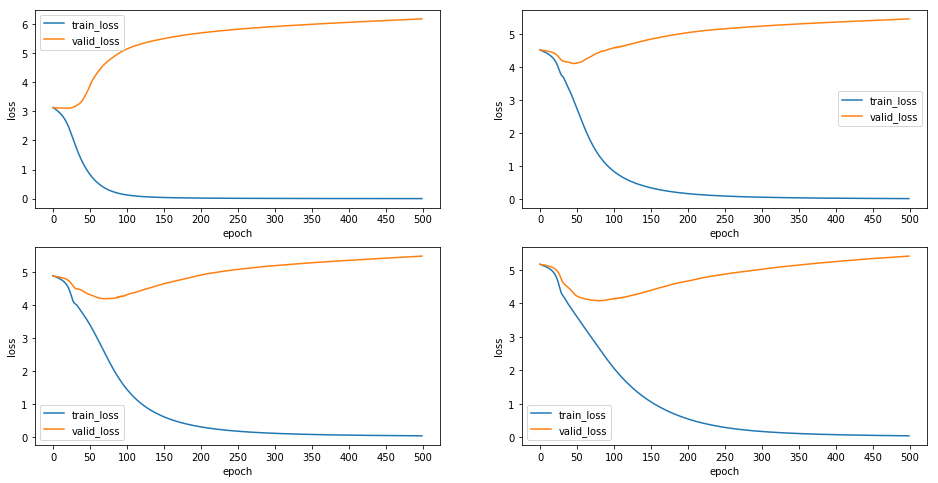

In [37]:
# plot the result
fig = plt.gcf()
fig.set_size_inches(16,8)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(epochs), [train_log[i][j]["train_loss"] for j in range(epochs)], label="train_loss")
    plt.plot(range(epochs), [train_log[i][j]["valid_loss"] for j in range(epochs)], label="valid_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, epochs + 1, math.floor(epoch / 10)))
    plt.legend()
plt.show()

In [42]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_finetuned.pth"
decoder_path = "data/decoder_finetuned.pth"
encoder_decoder = Pipeline(encoder_path, decoder_path)

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = PipelineDataset(root, train_captions[-1], transform)
dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

# caption images
descriptions = []
images = []
for i, (image_inputs, caps, cap_lengths) in enumerate(dataloader):
    image_inputs = Variable(image_inputs).cuda()
    descriptions += encoder_decoder.generate_text(image_inputs, captions.dict_idx2word, 50)
    images.append(image_inputs)

In [43]:
descriptions

['<START> classic design with contemporary style glass table . the base is steel coated legs . there is also a storage facility just below the top . the glass is attached through four bolts . <END>',
 '<START> a simple chair with wooden back rest and seating rest . the whole frame of the chair is powder coated stainless steel . it is brown and grey in colour . <END>',
 '<START> it is narrow console table . it is made from plywood . its size is quite good to place anything on it . it is grey in colour . <END>',
 '<START> panel based three cluster workstation having three nos . of semi-circular shaped workstation . it is blue and grey in colour . the base is of three legs <END>',
 '<START> a double cushion chair . the back rest cushion is larger than the seating rest . it is an arm chair . it is purple in colour . <END>',
 '<START> it is simple chiar with comfortable back rest and seating rest . the chair is floating between two arches of tough stainless steel legs . <END>',
 '<START> a 

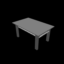

In [44]:
transforms.ToPILImage()(images[0].cpu().view(3, 64, 64))